Traffic data fluctuates constantly or is affected by time. Predicting it can be challenging, but this task will help sharpen your time-series skills. With deep learning, you can use abstract patterns in data that can help boost predictability.

Your task is to build a system that can be applied to help you predict traffic volume or the number of vehicles passing at a specific point and time. Determining this can help reduce road congestion, support new designs for roads or intersections, improve safety, and more! Or, you can use it to help plan your commute to avoid traffic!

The dataset provided contains the hourly traffic volume on an interstate highway in Minnesota, USA. It also includes weather features and holidays, which often impact traffic volume.

---

### The data:
The dataset is collected and maintained by UCI Machine Learning Repository. The target variable is `traffic_volume`. The dataset contains the following and has already been normalized and saved into training and test sets:

**Files:**  
`train_scaled.csv`, `test_scaled.csv`

| Column                  | Type        | Description                                                   |
|-------------------------|-------------|---------------------------------------------------------------|
| `temp`                 | Numeric     | Average temp in kelvin                                        |
| `rain_1h`              | Numeric     | Amount in mm of rain that occurred in the hour               |
| `snow_1h`              | Numeric     | Amount in mm of snow that occurred in the hour               |
| `clouds_all`           | Numeric     | Percentage of cloud cover                                    |
| `date_time`            | DateTime    | Hour of the data collected in local CST time                 |
| `holiday_` (11 columns)| Categorical | US National holidays plus regional holiday, Minnesota State Fair |
| `weather_main_` (11 columns)| Categorical | Short textual description of the current weather         |
| `weather_description_` (35 columns)| Categorical | Longer textual description of the current weather       |
| `traffic_volume`       | Numeric     | Hourly I-94 ATR 301 reported westbound traffic volume        |
| `hour_of_day`          | Numeric     | The hour of the day                                          |
| `day_of_week`          | Numeric     | The day of the week (0=Monday, Sunday=6)                    |
| `day_of_month`         | Numeric     | The day of the month                                         |
| `month`                | Numeric     | The number of the month                                      |
| `traffic_volume`       | Numeric     | Hourly I-94 ATR 301 reported westbound traffic volume        |

In [15]:
# Import necessary libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [16]:
# Read the traffic data from the CSV training and test files
train_scaled_df = pd.read_csv('train_scaled.csv')
test_scaled_df = pd.read_csv('test_scaled.csv')

# Convert the DataFrames to NumPy arrays
train_scaled = train_scaled_df.to_numpy()
test_scaled = test_scaled_df.to_numpy()

In [17]:
# Prepare the Data for Modeling
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Example data (replace with your actual dataset)
data = np.sin(np.linspace(0, 100, 1000))  # Example sine wave data
seq_length = 10

# Create sequences
sequences, targets = create_sequences(data, seq_length)

# Convert to PyTorch tensors
sequences = torch.tensor(sequences, dtype=torch.float32).unsqueeze(-1)  # Add feature dimension
targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(-1)

# Create DataLoader
dataset = TensorDataset(sequences, targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
# Create the Neural Network Model
class TrafficVolumePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TrafficVolumePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last output of the sequence
        return out

# Initialize the model
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1

model = TrafficVolumePredictor(input_size, hidden_size, num_layers, output_size)

In [19]:
# Train the Model
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()  # Set model to training mode
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

Epoch 1/20, Loss: 0.13854125142097473
Epoch 2/20, Loss: 0.09515868872404099
Epoch 3/20, Loss: 0.003919278271496296
Epoch 4/20, Loss: 0.001323769218288362
Epoch 5/20, Loss: 0.0004880219348706305
Epoch 6/20, Loss: 0.0002673164417501539
Epoch 7/20, Loss: 9.29990055738017e-05
Epoch 8/20, Loss: 8.752359281061217e-05
Epoch 9/20, Loss: 2.8957383619854227e-05
Epoch 10/20, Loss: 1.623019306862261e-05
Epoch 11/20, Loss: 1.0558531357673928e-05
Epoch 12/20, Loss: 6.608212970604654e-06
Epoch 13/20, Loss: 7.561679012724198e-06
Epoch 14/20, Loss: 4.757841907121474e-06
Epoch 15/20, Loss: 5.465830327011645e-06
Epoch 16/20, Loss: 6.199773906701012e-06
Epoch 17/20, Loss: 7.814277523721103e-06
Epoch 18/20, Loss: 4.187259492027806e-06
Epoch 19/20, Loss: 5.4311035455612e-06
Epoch 20/20, Loss: 8.520264600520022e-06


In [20]:
# Evaluate the Model
# Create test data (replace with your actual test set)
test_data = np.sin(np.linspace(100, 120, 200))  # Example sine wave test data
test_sequences, test_targets = create_sequences(test_data, seq_length)
test_sequences = torch.tensor(test_sequences, dtype=torch.float32).unsqueeze(-1)
test_targets = torch.tensor(test_targets, dtype=torch.float32).unsqueeze(-1)

# Evaluate the model
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(test_sequences)
    mse = criterion(predictions, test_targets)
    print(f"Test MSE: {mse.item()}")

Test MSE: 7.348484814428957e-06


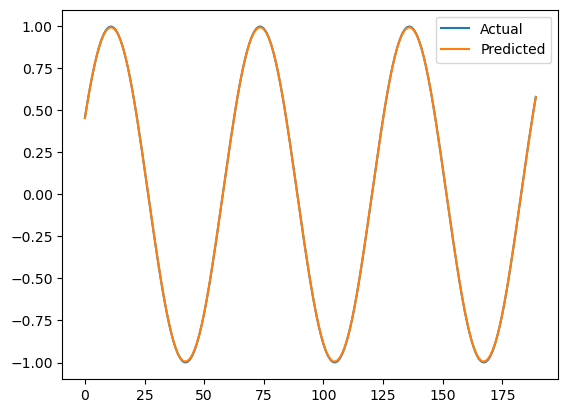

In [21]:
# Visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.plot(test_targets.numpy(), label="Actual")
plt.plot(predictions.numpy(), label="Predicted")
plt.legend()
plt.show()